## Importing stuff I need

In [1]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import time, os

from pixell import enmap,utils,reproject,enplot
from pixell.reproject import healpix2map,thumbnails
from pixell.curvedsky import alm2map,map2alm,almxfl

import numpy as np
import matplotlib.pyplot as plt

import healpy as hp
from healpy.fitsfunc import read_alm,read_map

# utils require orphics + pyfisher + enlib
from falafel import qe, utils

# my own file
import websky_stack_and_visualize as josh_websky

## Reading and opening files

In [2]:
# simulated maps file location
alm_filename = "../lensed_alm.fits"

alm_hp = read_alm(alm_filename)
print("alms: ", alm_hp.dtype, len(alm_hp))

# lensing convergence file
kap_filename = "kap.fits"

# don't need kappa map right now?

alms:  complex128 34043626


## Convert cell to pixell (equatorial CAR) format

In [3]:
# 0.5 (1 for now) arcmin resolution car geometry
shape, wcs = enmap.fullsky_geometry(res=np.deg2rad(1.5 / 60.))
# create empty map to overlay our map
omap = enmap.empty(shape, wcs, dtype=np.float32)
t1 = time.time()
alm_px = alm2map(alm_hp, omap)
t2 = time.time()
print("Took %0.5f seconds." % (t2 - t1))

Took 3.18280 seconds.


## Prepare appropriate data

In [5]:
LMIN = 300
LMAX = 3000

alms = map2alm(alm_px, lmax=LMAX)

# if i set beam to 1.0 does that include zero effect from the beam?
beam_fwhm = 1.0 # arcmin
noise_t = 10. # noise stdev in uK-arcmin
# ucls['TT'] = C_ell_TT
# tcls['TT'] = C_ell_TT + N_ell_TT 
ucls, tcls = utils.get_theory_dicts_white_noise(beam_fwhm, noise_t)

# filter map
# isotropic_filter(alm, tcls, lmin, lmax, ignore_te=True)
fTalm = utils.isotropic_filter([alms, alms*0., alms*0.],
                                tcls, LMIN, LMAX, ignore_te=True)[0]

# deconvolve beam
# fTalm = almxfl(fTalm, 1.0 / maps.gau ss_beam(ells, beams_fwhm))

fTalm.shape


(4504501,)

## Running reconstruction and getting output map

In [6]:
px = qe.pixelization(shape=shape, wcs=wcs)
recon_alms = qe.qe_all(px, ucls, fTalm=fTalm, fEalm=fTalm*0., fBalm=fTalm*0.,
                       mlmax=LMAX, estimators=['TT'])

kappa_map = alm2map(recon_alms['TT'], enmap.empty(shape, wcs, dtype=np.float32))
print(kappa_map.shape)

(7201, 14400)


## Plotting output map

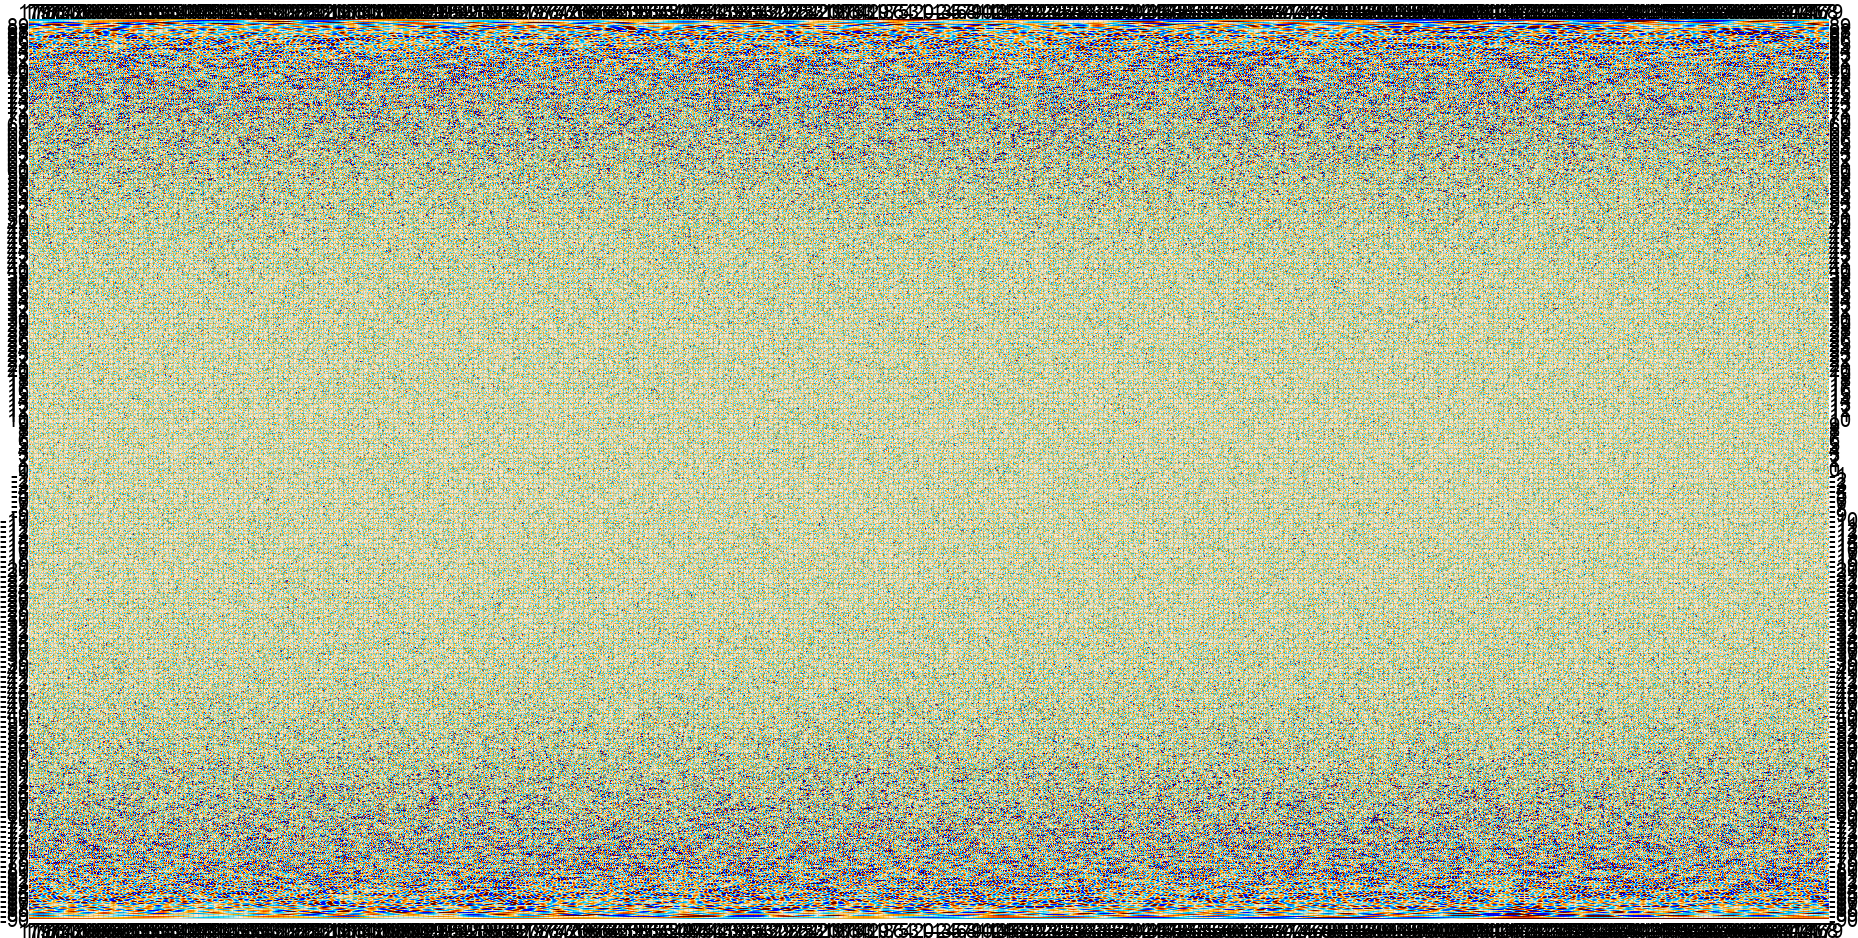

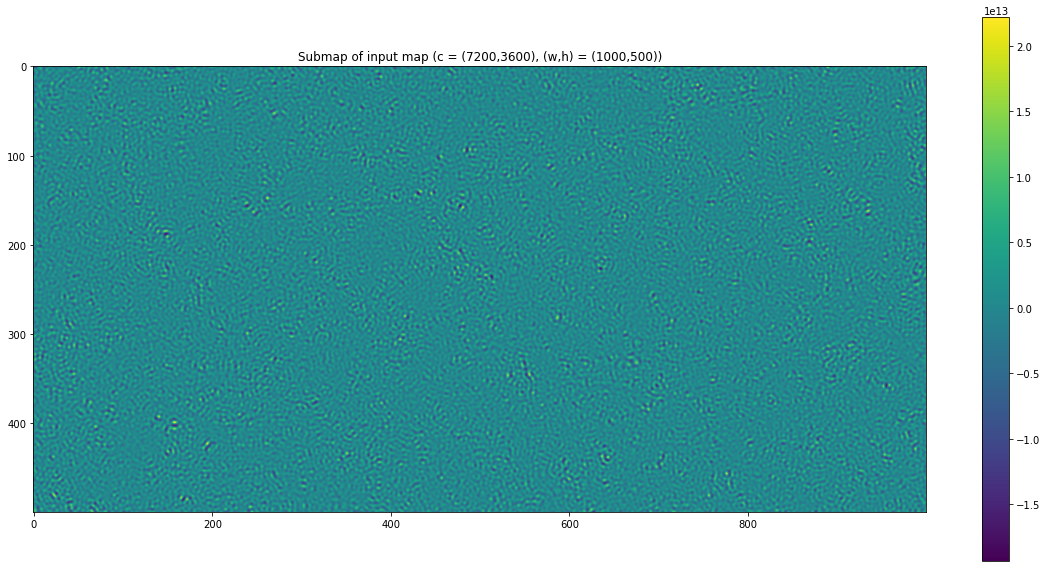

In [7]:
# enplot.plot(...,downgrade=8) 
plot = enplot.plot(kappa_map, downgrade=8)
enplot.show(plot)

# josh_websky.plot_map(kappa_map)

## Try stacking?

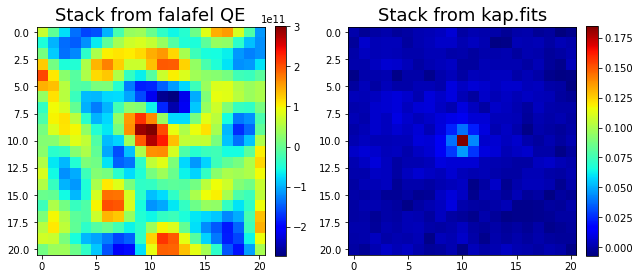

In [8]:
ra, dec = josh_websky.catalog_to_coords(filename="../halos_10x10.pksc")

RES = np.deg2rad(1.5 / 60.)
stack_map, avg_map = josh_websky.stack_average_random(kappa_map, ra, dec, Ncoords=1000,
                                                      radius=10*RES, res=RES)

# from given kap.fits file
kap_px = josh_websky.px_to_car("../kap.fits", res=RES)
stack_kap, avg_kap = josh_websky.stack_average_random(kap_px, ra, dec, Ncoords=1000,
                                                      radius=10*RES, res=RES)                                                     

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,18))

im1 = axes[0].imshow(avg_map, cmap='jet')
axes[0].set_title("Stack from falafel QE", fontsize=18)
im2 = axes[1].imshow(avg_kap, cmap='jet')
axes[1].set_title("Stack from kap.fits", fontsize=18)

fig.subplots_adjust(right=0.85)
fig.colorbar(im1, ax = axes[0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax = axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("reconstruction.png")
plt.show()